# CIIC5015 - Introduction to Artificial Intelligence
## Project 2 - Fully Connected Neural Networks
### Part 1 - Regression

Fernando J. Bermudez Medina - 802-18-0426

Import the necesary libraries & Classes
- Matplotlib
- NumPy
- Pandas
- PyTorch
    - `TensorDataset` & `DataLoader` for data processing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.utils as utils

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

### Download & Process the Data

To fetch the data to use for training, we will use the Pandas framework. The dataset will consist of a Pandas DataFrame as shown in the cell below. Once fetched, we will separate the features (Displacement, Horsepower, etc.) from the labels (MPG). We will also split the data in two sets, a training set and a testing set. Once split, we will normalize all the features for the training and testing sets using Z-Score normalization of the following form:

$$Z = \frac{x - \mu}{\sigma}$$

Where $\mu$ is the mean and $\sigma$ is the standard deviation

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True).dropna()

dataset.tail(n=30) # Output the last 30 rows of the DataFrame

# Split 80% dataset for training and 20% for testing
training_features = dataset.sample(frac=0.8, random_state=0).copy()
testing_features = dataset.drop(training_features.index).copy()

training_labels = training_features.pop('MPG')
testing_labels = testing_features.pop('MPG')

# Normalize all the data
normalized_training_features = (training_features - training_features.mean()) / training_features.std()
normalized_testing_features = (testing_features - testing_features.mean()) / testing_features.std()

### The Hyperparameters

We define next the parameters that we will use to fine-tune and adust how our models trains. The hyperparameters defined are as follows:
1. `number_of_features` - The number of training features the dataset has
2. `batch_size` - How many batches of data we will pass the network while training. Usually it is a number of the form $2^n$, where $n$ is an integer.
3. `learning_rate` - How far the model "jumps" when doing Gradient Descent, usually a value between 0 and 1.
4. `epochs` - How many times we will pass the model the same batches to do training

In [3]:
number_of_features = training_features.shape[1]
batch_size = 16
learning_rate = 0.01
epochs = 20

### Initalize the `Dataset` & `DataLoader`

Using PyTorch's `TensorDataset` & `DataLoader` classes, we load the training data and the labels to be separated into batches of size `batch_size` and to be trained in teh training loop later on. We first convert the Pandas DataFrames to PyTorch Tensors, and once that has been processed, we load the tensors into an instance of `DataLoader`.

In [4]:
normalized_features = torch.tensor(np.array(normalized_training_features), dtype=torch.float32)
labels = torch.tensor(np.array(training_labels), dtype=torch.float32)

# Create dataset and dataloader
train_dataset = TensorDataset(normalized_features, labels)
train_loader =  DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

### Define the Neural Networks to train

Using PyTorch's `nn.Linear` class, we can create a linear regression model that has one input layer and one output layer. We also create 2 extra regression models that contain 4 & 5 layers respectively. Each layer is stored inside an instance of `torch.nn.Sequential`. Since these are all reression models, they will all have an outputdimension of 1.

In [5]:
class LinearRegressionModel(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.layer = torch.nn.Linear(input_size, output_size)
        
    def forward(self, x):
        return self.layer(x)
    
class NNModel2(torch.nn.Module):
    def __init__(self, input_features):
        super(NNModel2, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_features, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 1)
        )
    
    def forward(self, x):
        return self.layers(x)
 

class NNModel3(torch.nn.Module):
    def __init__(self, input_features):
        super(NNModel3, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_features, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 30),
            torch.nn.ReLU(),
            torch.nn.Linear(30, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

### The Training Loop

Once we define the model and its hyperparameters, we can define the loop used for training. 

The algorithm follows the following pseudocode:

```
for an n number of epochs, do the following:
    for each batch in train_loader:
        reset gradients to 0
        make a prediction (forward pass)
        compute loss value for that prediction
        back propagate error to all neurons (backward pass)
        clip gradients if necesarry (NN2 & NN3) to avoid exploding gradients
        adjust gradients based on error and back propagation
        compute average batch loss and store it for plotting
```


In [6]:
def train_model(model, epochs, learning_rate, loss_list, network):
    print(f"Starting Neural Network {network} training")
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        running_loss = 0.0
        for index, (features, labels) in enumerate(train_loader, 0):
            optimizer.zero_grad()
            
            predictions = model(features)
            loss = criterion(predictions, labels.view(-1, 1))
            
            running_loss += loss.item()
                        
            loss.backward()
            if network != 1:
                utils.clip_grad_norm_(model.parameters(), max_norm=16, norm_type=2.0)
            optimizer.step()
            
            if (index + 1) % 20 == 0:
                print(f"Epoch: {epoch + 1:2d} - Index: {index + 1:2d} - Average Batch Loss: {running_loss / 20:.3f}")
                loss_list.append(running_loss / 20)
                running_loss = 0.0
                
    print(f"Finished Neural Network {network} training")


### Train Models

Once everything is defined and constructed, we can proceed to pass out three models through our training loop, in each loop we will store the values of the average loss per batch that the `DataLoader` returns in a list to be able to plot it later.

In [20]:
loss_list1 = []
regression_model = LinearRegressionModel(number_of_features, 1)
train_model(regression_model, epochs, learning_rate, loss_list1, 1)

Starting Neural Network 1 training
Epoch:  1 - Index: 20 - Average Batch Loss: 400.170
Epoch:  2 - Index: 20 - Average Batch Loss: 181.406
Epoch:  3 - Index: 20 - Average Batch Loss: 87.572
Epoch:  4 - Index: 20 - Average Batch Loss: 45.369
Epoch:  5 - Index: 20 - Average Batch Loss: 27.127
Epoch:  6 - Index: 20 - Average Batch Loss: 18.577
Epoch:  7 - Index: 20 - Average Batch Loss: 15.073
Epoch:  8 - Index: 20 - Average Batch Loss: 13.497
Epoch:  9 - Index: 20 - Average Batch Loss: 12.677
Epoch: 10 - Index: 20 - Average Batch Loss: 12.079
Epoch: 11 - Index: 20 - Average Batch Loss: 11.925
Epoch: 12 - Index: 20 - Average Batch Loss: 11.774
Epoch: 13 - Index: 20 - Average Batch Loss: 11.791
Epoch: 14 - Index: 20 - Average Batch Loss: 11.791
Epoch: 15 - Index: 20 - Average Batch Loss: 12.012
Epoch: 16 - Index: 20 - Average Batch Loss: 11.742
Epoch: 17 - Index: 20 - Average Batch Loss: 11.842
Epoch: 18 - Index: 20 - Average Batch Loss: 11.555
Epoch: 19 - Index: 20 - Average Batch Loss: 1

In [21]:
loss_list2 = []
nn_model2 = NNModel2(number_of_features)
train_model(nn_model2, epochs, learning_rate, loss_list2, 2)

Starting Neural Network 2 training
Epoch:  1 - Index: 20 - Average Batch Loss: 466.333
Epoch:  2 - Index: 20 - Average Batch Loss: 49.073
Epoch:  3 - Index: 20 - Average Batch Loss: 14.780
Epoch:  4 - Index: 20 - Average Batch Loss: 11.411
Epoch:  5 - Index: 20 - Average Batch Loss: 13.367
Epoch:  6 - Index: 20 - Average Batch Loss: 10.402
Epoch:  7 - Index: 20 - Average Batch Loss: 11.596
Epoch:  8 - Index: 20 - Average Batch Loss: 10.117
Epoch:  9 - Index: 20 - Average Batch Loss: 10.304
Epoch: 10 - Index: 20 - Average Batch Loss: 11.168
Epoch: 11 - Index: 20 - Average Batch Loss: 8.972
Epoch: 12 - Index: 20 - Average Batch Loss: 9.382
Epoch: 13 - Index: 20 - Average Batch Loss: 9.125
Epoch: 14 - Index: 20 - Average Batch Loss: 9.945
Epoch: 15 - Index: 20 - Average Batch Loss: 9.499
Epoch: 16 - Index: 20 - Average Batch Loss: 9.871
Epoch: 17 - Index: 20 - Average Batch Loss: 9.931
Epoch: 18 - Index: 20 - Average Batch Loss: 9.615
Epoch: 19 - Index: 20 - Average Batch Loss: 9.061
Epoc

In [9]:
loss_list3 = []
nn_model3 = NNModel3(number_of_features)
train_model(nn_model3, epochs, learning_rate, loss_list3, 3)

Starting Neural Network 3 training
Epoch:  1 - Index: 20 - Average Batch Loss: 460.414
Epoch:  2 - Index: 20 - Average Batch Loss: 38.699
Epoch:  3 - Index: 20 - Average Batch Loss: 15.144
Epoch:  4 - Index: 20 - Average Batch Loss: 11.867
Epoch:  5 - Index: 20 - Average Batch Loss: 12.359
Epoch:  6 - Index: 20 - Average Batch Loss: 13.423
Epoch:  7 - Index: 20 - Average Batch Loss: 11.870
Epoch:  8 - Index: 20 - Average Batch Loss: 11.337
Epoch:  9 - Index: 20 - Average Batch Loss: 12.037
Epoch: 10 - Index: 20 - Average Batch Loss: 12.231
Epoch: 11 - Index: 20 - Average Batch Loss: 10.111
Epoch: 12 - Index: 20 - Average Batch Loss: 9.881
Epoch: 13 - Index: 20 - Average Batch Loss: 11.367
Epoch: 14 - Index: 20 - Average Batch Loss: 12.447
Epoch: 15 - Index: 20 - Average Batch Loss: 10.089
Epoch: 16 - Index: 20 - Average Batch Loss: 10.950
Epoch: 17 - Index: 20 - Average Batch Loss: 10.450
Epoch: 18 - Index: 20 - Average Batch Loss: 10.334
Epoch: 19 - Index: 20 - Average Batch Loss: 11.

### Plot The Average Batch Loss For Each Model

Now, we take the batch loss values collected from our training process to see if the loss converged (or plateaued) to a certain value in each model.

To do this, we define two functions to help us visualize the data better using `Matplotlib.pyplot`
- `plot_loss(loss_list, n)`:
    - The method takes as parameter the lists of batch loss values from a number of networks `n` and plots them. The x axis represents the epoch, the y value the average batch loss of hte networks
- `accuracy(model, nn, epsilon)`:
    - The method takes as parameter the network to test, a number indicating what network it is (1, 2, 3) and a constant `epsilon` that will give us a range to test a predicted label against it's true value.

In [31]:
def plot_loss(loss_lists, n):
    for i in range(n):
        plt.plot(loss_lists[i], 'r' if i + 1 == 1 else 'b' if i + 1 == 2 else 'g', label="Linear Regression" if i + 1 == 1 else f"Neural Network {i + 1}") # Plot the loss function in red color
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, color='grey')
    plt.show()
    

def accuracy(model, nn, epsilon):
    correct = 0    
    with torch.no_grad():
        features = torch.tensor(np.array(normalized_testing_features), dtype=torch.float32)
        prediction = model.forward(features)
        i = 0
        total = len(testing_labels)
        for label in testing_labels:
            # print(f"{label.item() - epsilon} <= {prediction[i].item()} <= {label.item() + epsilon}")
            correct += 1 if label - epsilon <= prediction[i].item() <= label + epsilon else 0
            i += 1
            
    print(f"Accuracy of Neural Network {nn}: {100 * correct // total}%")


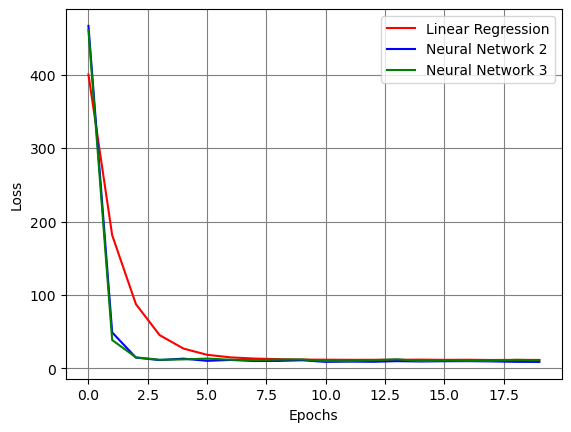

Accuracy of Neural Network 1: 89%
Accuracy of Neural Network 2: 94%
Accuracy of Neural Network 3: 94%


In [32]:
plot_loss([loss_list1, loss_list2, loss_list3], 3)
accuracy(regression_model, 1, 5)
accuracy(nn_model2, 2, 5)
accuracy(nn_model3, 3, 5)


### Conclusions

Following the process done in this notebook, we can answer the following question:

1. Which of the three models had the least amount of error for validation? 
    - From the three models, we can see that the models that have multiple layers have a minimal difference in accuracy, and both models have almost the same loss values and they converge almost to the same value. The only model that stands out in terms of accuracy is model 1 sicne it always contains a constant value of around 89%. This shows clearly that model 1 is low in accuracy due to the lack of epochs to train. To conclude, the models that have the least amount of error for validation are models 2 & 3.